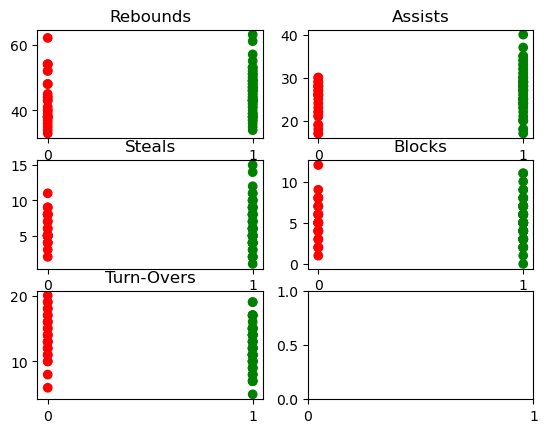

In [1]:
from nba_api.stats.endpoints import boxscoreadvancedv2
from nba_api.stats.endpoints import teamgamelogs
from nba_api.stats.endpoints import boxscorefourfactorsv2
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd
import matplotlib.pyplot as plt

nba_teams = teams.get_teams()
# Select the dictionary for the Celtics, which contains their team ID
celtics = [team for team in nba_teams if team['abbreviation'] == 'BOS'][0]
celtics_id = celtics['id']

# Query for games where the Celtics were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=celtics_id)
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]

games = games[['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'MATCHUP', 'WL', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV']]

games['WL'] = games['WL'].map(lambda x: 1 if x == 'W' else 0)

season_id = '22022'

games_filtered = games[games['SEASON_ID'] == season_id]

fig, ax = plt.subplots(3,2)

colors = {0: 'red', 1: 'green'}

ax[0, 0].scatter(games_filtered['WL'], games_filtered['REB'], c=games_filtered['WL'].map(colors))
ax[0, 0].set_title('Rebounds')
ax[0, 1].scatter(games_filtered['WL'], games_filtered['AST'], c=games_filtered['WL'].map(colors))
ax[0, 1].set_title('Assists')
ax[1, 0].scatter(games_filtered['WL'], games_filtered['STL'], c=games_filtered['WL'].map(colors))
ax[1, 0].set_title('Steals')
ax[1, 1].scatter(games_filtered['WL'], games_filtered['BLK'], c=games_filtered['WL'].map(colors))
ax[1, 1].set_title('Blocks')
ax[2, 0].scatter(games_filtered['WL'], games_filtered['TOV'], c=games_filtered['WL'].map(colors))
ax[2, 0].set_title('Turn-Overs')

for ax in ax.flat:
  ax.set_xticks([0, 1])
